# BinWaves example in Cantabria (Validation)

**In this notebook**: 
<br><br>
Here waves are reconstructed at the buoy location for comparison.
<br><br>
Steps:
- Buoy is loaded.
- Kp propagation coefficients and hindcast reconstruction is made at the buoy location.
- Comparison plots and statistics are shown.

In [9]:
import pandas as pd
import xarray as xr

# Load buoy data and kps

buoy_waves = pd.read_pickle("outputs/buoy_bulk_parameters.pkl").loc["2010"]

kp_coeffs = (
    xr.open_dataset("outputs/kp_coeffs_buoy.nc")
    # 462805.45 4815333.56
)
kp_coeffs

<xarray.Dataset> Size: 25MB
Dimensions:   (case_num: 692, site: 1, freq: 38, dir: 120)
Coordinates:
  * case_num  (case_num) int64 6kB 0 2 5 6 8 9 10 ... 690 691 692 693 694 695
  * site      (site) int64 8B 2
  * freq      (freq) float64 304B 0.03 0.033 0.0363 0.0399 ... 0.8273 0.9096 1.0
  * dir       (dir) float64 960B 1.5 4.5 7.5 10.5 ... 349.5 352.5 355.5 358.5
    time      datetime64[ns] 8B ...
    lat       float64 8B ...
    lon       float64 8B ...
Data variables:
    efth      (case_num, site, freq, dir) float64 25MB ...

In [5]:
from utils.operations import transform_ERA5_spectrum

model_parameters = pd.read_csv("outputs/swan_cases.csv").to_dict(orient="list")

# Load interest spectra

offshore_spectra, offshore_spectra_case = transform_ERA5_spectrum(
    era5_spectrum=xr.open_dataset("outputs/ERA5_offshore_spectra.nc"),
    subset_parameters=model_parameters,
    available_case_num=kp_coeffs.case_num.values,
)
offshore_spectra_case

<xarray.DataArray 'efth' (case_num: 692, time: 17520)> Size: 97MB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.46727731e-06, 2.74353282e-06, 0.00000000e+00, ...,
        2.51669694e-04, 3.10641143e-04, 3.62449514e-04],
       [1.91092512e-03, 1.89029968e-03, 1.94021481e-03, ...,
        5.75008078e-03, 6.67565053e-03, 7.74921899e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
      shape=(692, 17520))
Coordinates:
  * case_num   (case_num) int64 6kB 0 2 5 6 8 9 10 ... 690 691 692 693 694 695
    longitude  float32 4B 356.1
    latitude   float32 4B 43.82
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00

In [6]:
from bluemath_tk.waves.binwaves import reconstruc_spectra

# Reconstruct spectra

reconstructed_onshore_spectra = reconstruc_spectra(
    offshore_spectra=offshore_spectra_case,
    kp_coeffs=kp_coeffs,
)
# reconstructed_onshore_spectra.to_netcdf("outputs/reconstructed_spectra_san_buoy.nc")

# reconstructed_onshore_spectra = xr.open_dataset(
#     "outputs/reconstructed_spectra_san_buoy.nc"
# )
reconstructed_onshore_spectra

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:42713
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44915'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37317'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:43859 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43859
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:47034
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:41485 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:41485
INFO:distributed.core:Starting established connection to tcp://127

<xarray.Dataset> Size: 639MB
Dimensions:    (site: 1, freq: 38, dir: 120, time: 17520)
Coordinates:
  * site       (site) int64 8B 2
  * freq       (freq) float64 304B 0.03 0.033 0.0363 ... 0.8273 0.9096 1.0
  * dir        (dir) float64 960B 1.5 4.5 7.5 10.5 ... 349.5 352.5 355.5 358.5
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00
    lat        float64 8B 0.0
    lon        float64 8B 0.0
    longitude  float32 4B 356.1
    latitude   float32 4B 43.82
Data variables:
    efth       (time, site, freq, dir) float64 639MB 7.31e-10 ... 1.56e-06

/opt/conda/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:512: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)
/opt/conda/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:512: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='Hs - Buoy [m]', ylabel='Hs - BinWaves [m]'>,
        <Axes: xlabel='Tp - Buoy [s]', ylabel='Tp - BinWaves [s]'>,
        <Axes: xlabel='Dir - Buoy [°]', ylabel='Dir - BinWaves [°]'>],
       dtype=object))

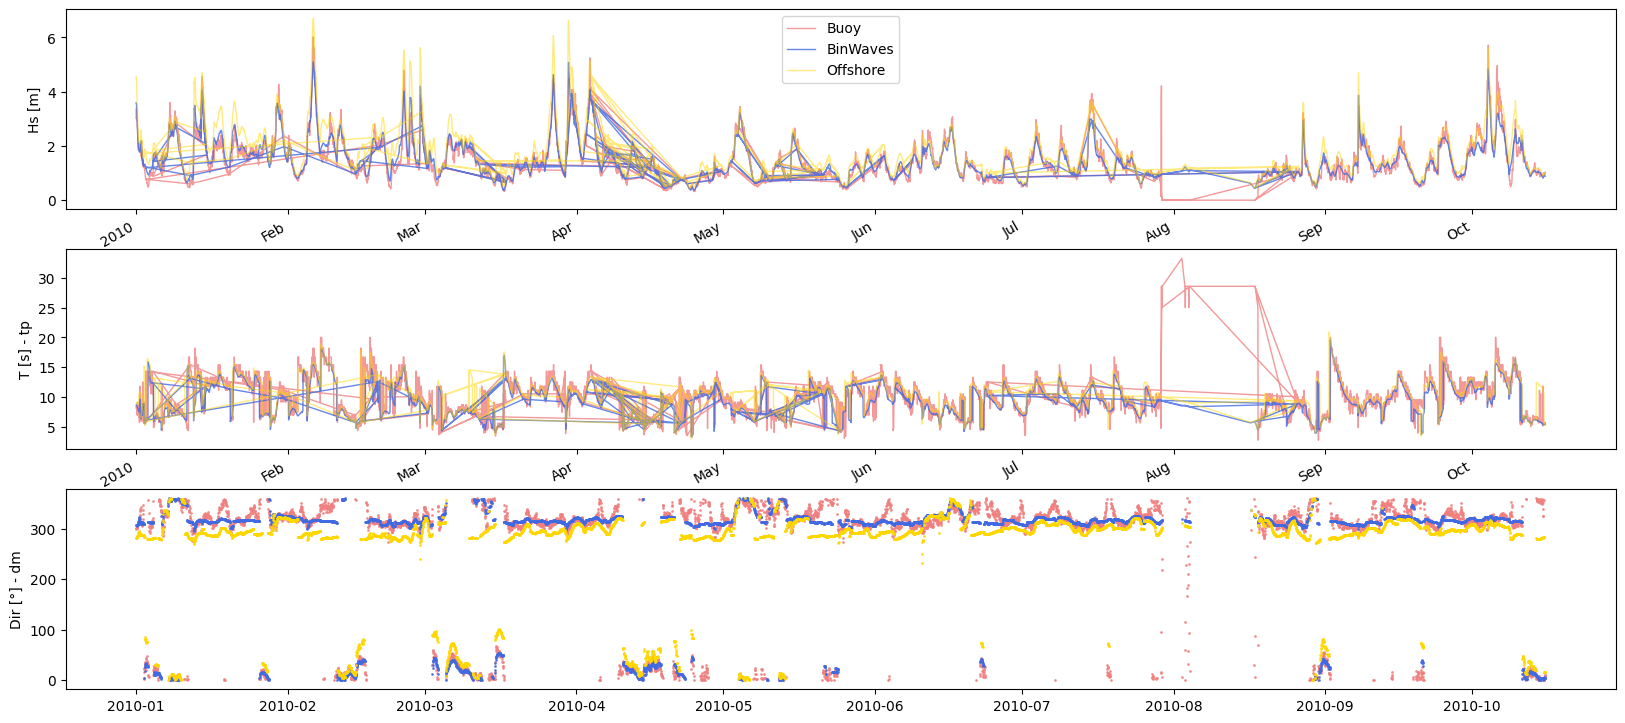

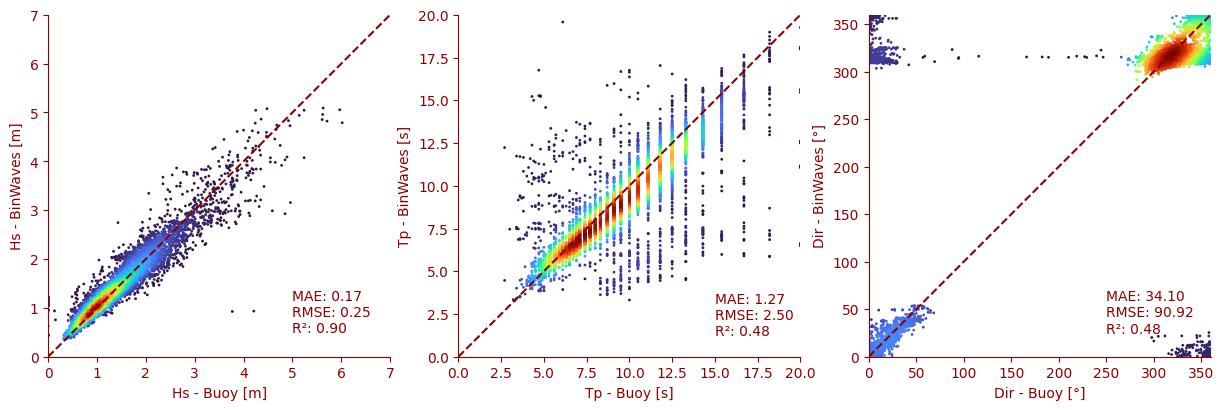

: 

In [ ]:
from utils.plotting import plot_wave_series

# Plot reconstructed bulk parameters vs buoy data

plot_wave_series(
    buoy_data=buoy_waves,
    binwaves_data=reconstructed_onshore_spectra.sel(
        site=2, time=buoy_waves.index, method="nearest"
    ).spec,
    offshore_data=offshore_spectra.sel(
        time=buoy_waves.index, method="nearest"
    ).spec,
    times=buoy_waves.index.values,
)